Enter company ticker (e.g., AAPL, TSLA, MSFT): MSFT
How many years of historical data? (1-5): 2


/tmp/ipython-input-27-1046544068.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Fetching MSFT data from 2023-07-13 to 2025-07-12...

Success! Got 501 trading days of data
Price             Open        High         Low       Close    Volume
Ticker            MSFT        MSFT        MSFT        MSFT      MSFT
Date                                                                
2025-07-09  500.299988  506.779999  499.739990  503.510010  18659500
2025-07-10  503.049988  504.440002  497.750000  501.480011  16492100
2025-07-11  498.470001  505.029999  497.799988  503.320007  16455000

Using 90 days lookback period

Training model...
Epoch 1/30



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0721
Epoch 2/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0116
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0081
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0063
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0065
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063
Epoch 7/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0064
Epoch 8/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0058
Epoch 9/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0058
Epoch 10/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0052
Epoch 11/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0049
Epoch 12/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0050
Epoch 13/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0047
Epoch 14/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0047
Epoch 15/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0045
Epoch 16/30
26/26 

/tmp/ipython-input-27-1046544068.py:96: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  current_price = float(data['Close'].iloc[-1])  # Explicit conversion to float


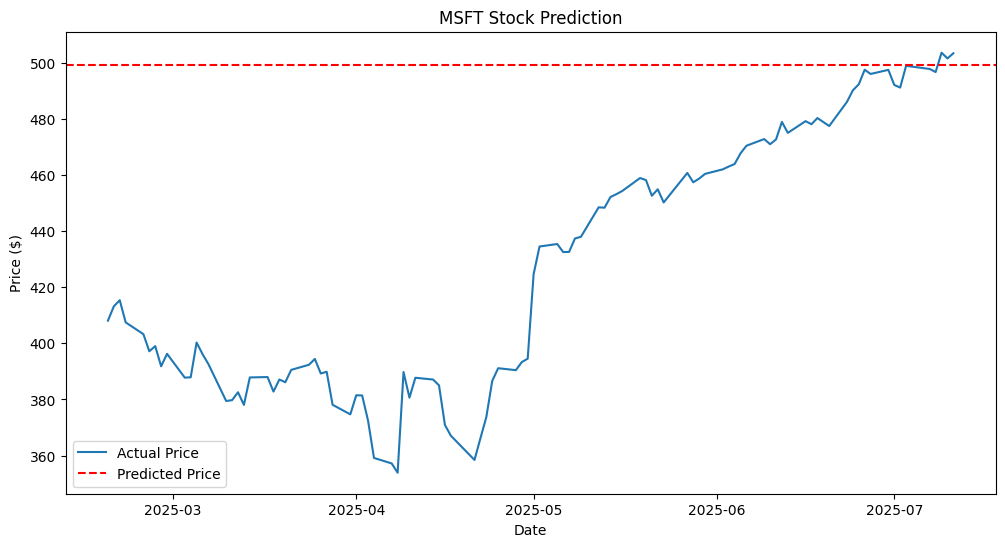


============== COMPARISON ==============
Simple 90-day Average: $429.16
LSTM Predicted Price: $499.14
Difference: $+69.98 (+16.31%)

🔍 Significant difference detected - LSTM found strong trends


/tmp/ipython-input-27-1046544068.py:130: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  simple_avg = float(data['Close'][-lookback:].mean())  # Convert to float


In [27]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from datetime import datetime, timedelta

# ======================
# 1. SETUP & CONFIGURATION
# ======================
random.seed(42)
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# ======================
# 2. USER INPUT
# ======================
ticker = input("Enter company ticker (e.g., AAPL, TSLA, MSFT): ").upper()
years = float(input("How many years of historical data? (1-5): "))

# ======================
# 3. FETCH LIVE DATA
# ======================
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=years*365)).strftime('%Y-%m-%d')

print(f"\nFetching {ticker} data from {start_date} to {end_date}...")
data = yf.download(ticker, start=start_date, end=end_date)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

if len(data) < 60:
    raise ValueError(f"Only {len(data)} days available - need at least 60 trading days")

print(f"\nSuccess! Got {len(data)} trading days of data")
print(data.tail(3))

# ======================
# 4. PREPROCESSING
# ======================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# ======================
# 5. DYNAMIC LOOKBACK
# ======================
lookback = min(90, len(data) - 31)  # 3 months or max available
print(f"\nUsing {lookback} days lookback period")

# ======================
# 6. CREATE TRAINING DATA
# ======================
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i-lookback:i])
    y.append(scaled_data[i, 3])  # Close price

X, y = np.array(X), np.array(y)

# ======================
# 7. BUILD MODEL
# ======================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# ======================
# 8. TRAIN
# ======================
print("\nTraining model...")
history = model.fit(X, y, epochs=30, batch_size=16, verbose=1)

# ======================
# 9. PREDICT
# ======================
last_sequence = scaled_data[-lookback:].reshape(1, lookback, -1)
prediction = model.predict(last_sequence, verbose=0)[0,0]

# Inverse transform
dummy = np.zeros((1, scaled_data.shape[1]))
dummy[0, 3] = prediction
predicted_price = scaler.inverse_transform(dummy)[0, 3]

# ======================
# 10. RESULTS (FULLY FIXED VERSION)
# ======================
current_price = float(data['Close'].iloc[-1])  # Explicit conversion to float
change_pct = (predicted_price - current_price)/current_price * 100

print("\n" + "="*40)
print(f"{ticker} Stock Analysis")
print("="*40)
print(f"Current Price: ${current_price:.2f}")
print(f"Predicted Price: ${predicted_price:.2f} ({change_pct:+.2f}%)")

if change_pct > 2:
    print("\n🚀 Recommendation: BUY (Expected Growth)")
elif change_pct < -2:
    print("\n⚠️ Recommendation: SELL (Expected Decline)")
else:
    print("\n🔄 Recommendation: HOLD (Neutral Outlook)")

print("\nNote: Always consider other market factors")
print("="*40)

# ======================
# 11. VISUALIZATION
# ======================
plt.figure(figsize=(12,6))
plt.plot(data.index[-100:], data['Close'].tail(100), label='Actual Price')
plt.axhline(predicted_price, color='r', linestyle='--', label='Predicted Price')
plt.title(f"{ticker} Stock Prediction")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# ======================
# PREDICTION COMPARISON (FIXED VERSION)
# ======================
#simple_avg = float(data['Close'][-lookback:].mean())  # Convert to float
#predicted_price = float(predicted_price)  # Ensure numeric type

#print(f"\n{' COMPARISON ':=^40}")
#print(f"Simple {lookback}-day Average: ${simple_avg:.2f}")
#print(f"LSTM Predicted Price: ${predicted_price:.2f}")
#print(f"Difference: ${predicted_price-simple_avg:+.2f} ({((predicted_price/simple_avg)-1)*100:+.2f}%)")

#if abs(predicted_price - simple_avg) > simple_avg * 0.05:  # >5% difference
   # print("\n🔍 Significant difference detected - LSTM found strong trends")
#else:
 #   print("\n🔍 Similar to average - market shows mean-reverting behavior")